In [ ]:
import numpy as np
import os
import time as t
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.data import AUTOTUNE
from tensorflow.keras import  Model , Input
from tensorflow.keras.layers import  Conv2D , MaxPool2D , GlobalAveragePooling2D , Flatten , Dense  , BatchNormalization , Activation , Add , Dropout
from tensorflow.keras.utils import load_img , image_dataset_from_directory , img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50 , EfficientNetB1 , MobileNetV3Small  , VGG16
from tensorflow.keras.callbacks import CSVLogger , ReduceLROnPlateau

# Exploring and spliting dataset

In [ ]:
## Read folder content

def read_images_data(data_dir) :
    """
    Read data from diroctory
    data_dir : data diroctory
    """
    try :
        classes = os.listdir(data_dir)
        return classes
    except Exception as e :
        print(f"An error occurred: {e}")

In [ ]:
DATA_DIR = r'/kaggle/input/garbage-classification/Garbage classification/Garbage classification'
classes = read_images_data(DATA_DIR)
print(f' - classes exist in data : {classes}')

 - classes exist in data : ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [ ]:
## Number of images in each class
def number_images(data_dir , classes_name) :
    """
    display number of images in each class
    data_dir : data diroctory
    classes_name : list of classes in data
    """
    list_dirs = [os.path.join(data_dir , c) for c in classes_name]
    images_each_class = [os.listdir(ld) for ld in list_dirs]
    nbr_images_each_class = [len(os.listdir(ld)) for ld in list_dirs]

    plt.figure(figsize=(12,4) , dpi=100)
    sns.barplot(y=nbr_images_each_class , x=classes_name)
    plt.xlabel('Classes')
    plt.ylabel('Number of images')

    return list_dirs , nbr_images_each_class;

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


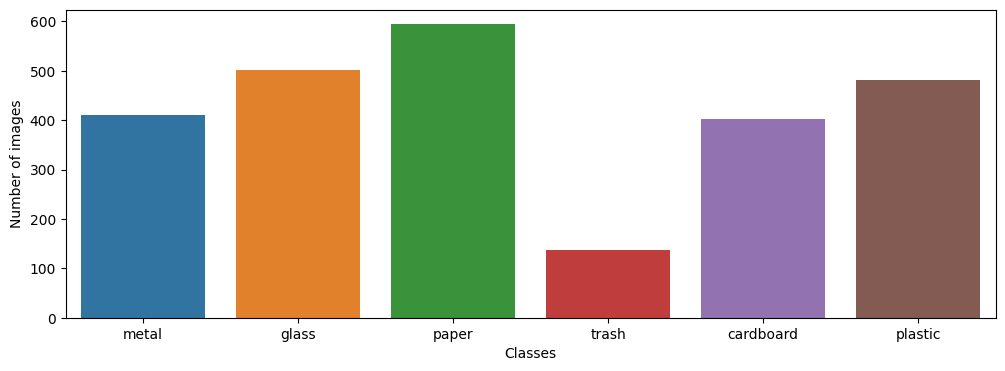

In [ ]:
list_dirs , nbr_images_each_class = number_images(DATA_DIR , classes)

In [ ]:
## Display rendom images

def choice_random_images_for_each_classe(list_dir_data,nbr_random_images=4) :
    """
    choice dircoctories of random images from each class
    list_dir_data : list of classes diroctory
    nbr_random_images : number of images from each class
    """
    random_dir_class_images = []
    for c in list_dir_data :
        class_images = os.listdir(c)
        random_class_images = np.random.choice(class_images,nbr_random_images)
        random_dir_class_images.append([os.path.join(c, img) for img in random_class_images])
    list_dir_images = np.array(random_dir_class_images).reshape(len(list_dir_data),nbr_random_images)
    return list_dir_images

def display_random_images(list_dir_data,list_classes_name,n_classes=2,nbr_random_images=4) :
    """
    disolay random images from each class
    list_dir_data : list of classes diroctory
    list_classes_name : name of classes (list)
    n_classes : Number of classes (binary = 2 or muticlassification > 2 )
    nbr_random_images : number of images from each class
    """
    fig , ax = plt.subplots(ncols=nbr_random_images,nrows=n_classes)
    fig.set_size_inches(10,8)
    fig.suptitle('\nRandom images for each classe\n',c='gray',fontsize=20)
    random_dir_class_images = choice_random_images_for_each_classe(list_dir_data , nbr_random_images=nbr_random_images)

    for i,cn in enumerate(list_classes_name) :
        for j,images_dir in enumerate(random_dir_class_images[i]) :
            img = load_img(images_dir)
            ax[i,j].imshow(img,aspect='equal')
            ax[i,j].set_title(f'{cn} image {j+1}')
            ax[i,j].axis('off')
    plt.tight_layout()
    plt.show()

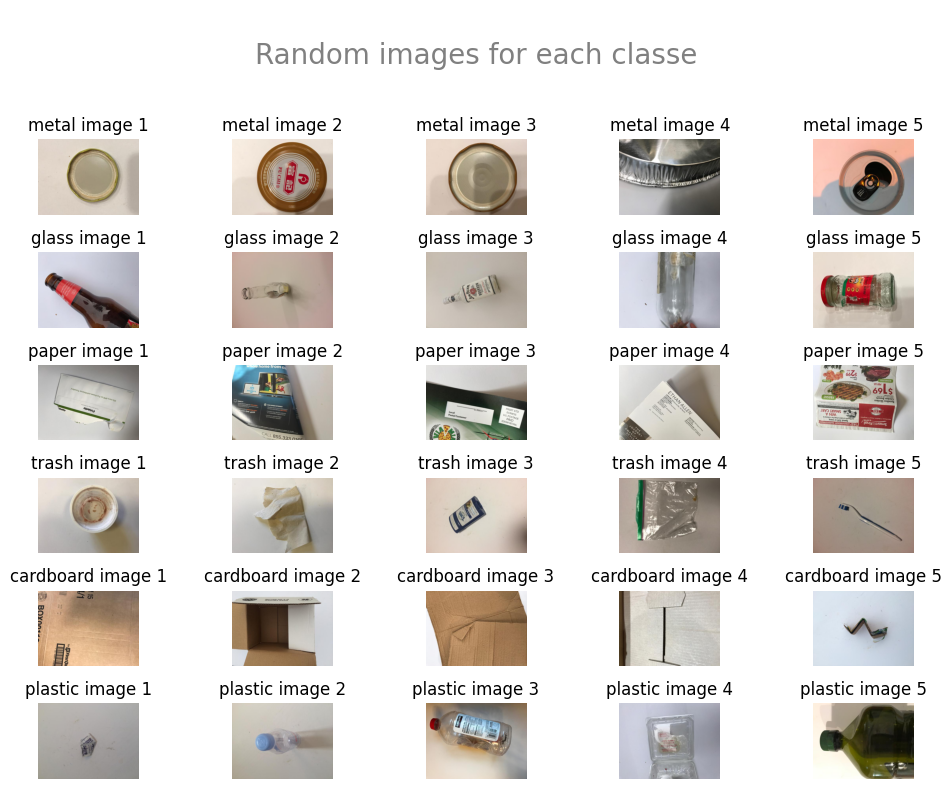

In [ ]:
nbr_classes = len(classes)
display_random_images(list_dirs,classes,n_classes=nbr_classes,nbr_random_images=5)

In [ ]:
## Spliting data

def split_data(data_dir , label_model='binary' , batch_size=32 , image_size = (200,200) , percentage_val_data=0.2) :
    train_data , validation_data = image_dataset_from_directory(
        directory=data_dir,
        label_mode= label_model,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=101,
        validation_split=percentage_val_data,
        subset='both'
    )

    train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

    return train_data,validation_data

In [ ]:
training_data , validation_data = split_data(DATA_DIR , label_model='categorical' , batch_size=32 , image_size = (100,100) , percentage_val_data=0.30)

Found 2527 files belonging to 6 classes.
Using 1769 files for training.
Using 758 files for validation.


In [ ]:
## Example of one batch

def information_one_batch(data ) :
    """
    Give some information (Value maximal of pixels , Value minimal of pixels , Shape of one batch image , Shape of one batch label)
    data : training data or validation data
    """
    for images , labels in data.take(1) :
        example_batch_image = images
        example_batch_label = labels
    print(f' - Value maximal of pixels : {np.max(example_batch_image)}')
    print(f' - Value minimal of pixels : {np.min(example_batch_image)}')
    print(f' - Shape of one batch image : {example_batch_image.shape}')
    print(f' - Shape of one batch label : {example_batch_label.shape}')

In [ ]:
information_one_batch(training_data)

 - Value maximal of pixels : 255.0
 - Value minimal of pixels : 0.0
 - Shape of one batch image : (32, 100, 100, 3)
 - Shape of one batch label : (32, 6)


# CNN Models

## Custom CNN

In [ ]:
## Custom CNN

class Res_Block(Model) :

    """
    Creat Resedual blocks
    Res_Block inherit from Model class
    __init__ : class construcure (for intialize the attributs)
    call : Creat Resedual block using functional implementation

    """

    def __init__(self , filters=64 , kernel_size=(3,3)  ) :

        super(Res_Block, self).__init__(name='')
        self.conv1 = Conv2D(filters, kernel_size, padding='same')
        self.batchNorm1 = BatchNormalization()
        self.activ_1 = Activation('relu')
        self.conv2 = Conv2D(filters, kernel_size , padding='same')
        self.batchNorm2 = BatchNormalization()
        self.add = Add()

    def call (self , inputs) :
        x = inputs
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.activ_1(x)
        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = self.add([x , inputs])
        x = self.activ_1(x)
        return x

In [ ]:
class CNN_model(Model) :
    """
    Creat custom cnn model architecture
    __init__ : class construcure (for intialize the attributs)
    call : Creat model architecture using functional implementation
    """

    def __init__(self, units_dense_1 = 256 , units_dense_2 = 128 , num_classes=3):
        super(CNN_model, self ).__init__()
        self.conv_1 = Conv2D(64, (7,7))
        self.bn_1 = BatchNormalization()
        self.act = Activation('relu')
        self.max_pool_1 = MaxPool2D((3, 3))
        self.ida = Res_Block(64, 3)
        self.conv_2 = Conv2D(64, (3,3))
        self.bn_2 = BatchNormalization()
        self.max_pool_2 = MaxPool2D((3, 3))
        self.global_pool = GlobalAveragePooling2D()
        self.flatten = Flatten()
        self.dense_1 = Dense(units = units_dense_1 , activation='relu')
        self.dropout = Dropout(0.3)
        self.dense_2 = Dense(units = units_dense_2 , activation='relu')
        self.classifier = Dense(num_classes,activation='softmax')


    def call(self,inputs) :

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = self.act(x)
        x = self.max_pool_1(x)
        for _ in range(5) :
            x = self.ida(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.max_pool_2(x)
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dropout(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [ ]:
## Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-10
)
## csv files to save accurcies and losses for each model

csv_files = {
    'custom_cnn_model' : 'custom_cnn_model.csv' ,
    'resnet50' : 'resnet50.csv',
    'mobilenet' : 'mobilenet.csv',
    'efficientnet' : 'efficientnet.csv',
    'vgg16' : 'vgg16.csv'
}


In [ ]:
cnn_custom_model = CNN_model(num_classes=6)
cnn_custom_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy' ])

In [ ]:
EPOCHS= 20
start_time = t.time()
hist_cnn_custom_model = cnn_custom_model.fit(
    training_data,
    epochs=EPOCHS,
    validation_data=validation_data,
    callbacks = [reduce_lr , CSVLogger(csv_files['custom_cnn_model'])]
)
end_time = t.time()
runing_time = end_time - start_time

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.1907 - loss: 23.5058 - val_accuracy: 0.3852 - val_loss: 1.5005 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3620 - loss: 1.5612 - val_accuracy: 0.3931 - val_loss: 1.5121 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4162 - loss: 1.4732 - val_accuracy: 0.4420 - val_loss: 1.4658 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4382 - loss: 1.4263 - val_accuracy: 0.4485 - val_loss: 1.3754 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4291 - loss: 1.4169 - val_accuracy: 0.4604 - val_loss: 1.3099 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4758 - loss: 1.3432 - val_accuracy: 0.4868 - val_loss: 1.3140 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4584 - loss: 1.3654 - val_accuracy:

In [ ]:
def plot_val_train_accuracy(train_val_df , model_name='') :
    plt.figure(figsize=(12,4) , dpi=100)
    sns.lineplot(x=train_val_df['epoch'] , y=train_val_df['val_accuracy'] ,marker = 'o', label='validation accuracy')
    sns.lineplot(x=train_val_df['epoch'] , y=train_val_df['accuracy'] ,marker = 'o',  label='train accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(f'\n{model_name}\n',c='gray',fontsize=14);

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

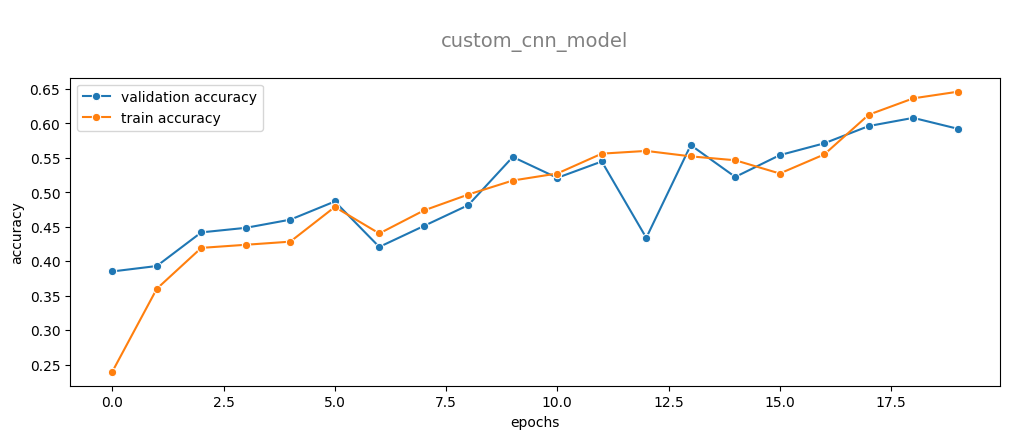

In [ ]:
## display train and validation accuracies and losses
custom_cnn_model_df = pd.read_csv(csv_files['custom_cnn_model'])
plot_val_train_accuracy(custom_cnn_model_df , 'custom_cnn_model')

## Transfer learning

In [ ]:
class ModelBuilder(Model):

    """
    Building models using pre-trained model
    __init__ : class construcure (for intialize the attributs)
              input_image_size : size of input image
              model_name : name of pre-trained model (eg. vgg16 , ResNet , MobileNet ... )
              layer_name :  The last layer to extract features from
              fine_tune_at :  Number of layers to fine-tune
              learning_rate : Define your learning rate

    _get_pre_trained_model : return base model and  output of last_layer

    _classifier_head : update the top of model (Adding some layers) for your classification problem
    build_model  : concatenate _get_pre_trained_model and _classifier_head functions to create final model

    """
    def __init__(self, input_image_size, model_name, layer_name, fine_tune_at=200, learning_rate=0.001):
        self.input_image_size = input_image_size
        self.model_name = model_name
        self.layer_name = layer_name
        self.fine_tune_at = fine_tune_at
        self.learning_rate = learning_rate
        self.model_dict = {
            'resNet50': ResNet50,
            'efficientNetB': EfficientNetB1,
            'mobileNet': MobileNetV3Small,
            'Inception': InceptionV3,
            'VGG16': VGG16
        }

    def _get_pre_trained_model(self):
        if self.model_name not in self.model_dict:
            raise ValueError(f"Error: Unsupported model name '{self.model_name}'. Choose from {list(self.model_dict.keys())}.")

        # Load the base model
        base_model = self.model_dict[self.model_name](input_shape=self.input_image_size, include_top=False, weights='imagenet')
        base_model.trainable = True

        # Freeze layers up to fine-tune point
        for layer in base_model.layers[:self.fine_tune_at]:
            layer.trainable = False

        # Extract specified layer output
        try:
            last_layer = base_model.get_layer(self.layer_name)
            return base_model, last_layer.output
        except Exception as e:
            print(f"Error in pre-trained model setup: {e}")

    def _classifier_head(self, input_tensor):
        x = Flatten()(input_tensor)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.4)(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.4)(x)
        output = Dense(6, activation='softmax')(x)
        return output

    def build_model(self):
        # Define input layer
        inputs = Input(shape=self.input_image_size)

        # Get pre-trained model and its output
        pt_model, features = self._get_pre_trained_model()
        if pt_model is None or features is None:
            raise ValueError("Pre-trained model setup failed.")

        # Apply classifier head on top of pre-trained features
        classifier_output = self._classifier_head(features)

        # Build final model
        model = Model(inputs=pt_model.input, outputs=classifier_output)

        # Compile model
        model.compile(
            optimizer=Adam(
                learning_rate=self.learning_rate,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-08
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model


In [ ]:
# Example values, replace them with the ones for your specific project
EPOCHS= 20
input_image_size = (100,100 , 3)  # Replace with your image input shape
models_name = ['resNet50' , 'mobileNet' , 'efficientNetB' , 'VGG16']       # Choose a model, e.g., 'resNet50', 'efficientNetB', etc.
layers_name = ['conv5_block3_out' ,'activation_13' , 'block6b_bn' , 'block5_conv3']     # The last layer to extract features from
fine_tune_at = 200                 # Number of layers to fine-tune
learning_rate = 0.001              # Define your learning rate

### ResNet50 pre-trained model

In [ ]:
# Step 1: Initialize ModelBuilder
model_builder_resnet = ModelBuilder(input_image_size, models_name[0], layers_name[0], fine_tune_at, learning_rate)

# Step 2: Build the model
resnet_model = model_builder_resnet.build_model()

# Step 3: Train the model
start_time = t.time()
history_resnet50 = resnet_model.fit(
    training_data,                     # Your training dataset
    validation_data=validation_data,       # Your validation dataset
    epochs=EPOCHS,                      # Define the number of epochs
    callbacks = [reduce_lr , CSVLogger(csv_files['resnet50'])]
)
end_time = t.time()
runing_time_resnet = end_time - start_time


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.3941 - loss: 10.6912 - val_accuracy: 0.6768 - val_loss: 1.6604 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6931 - loss: 1.9996 - val_accuracy: 0.7098 - val_loss: 1.2102 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7412 - loss: 1.2734 - val_accuracy: 0.7520 - val_loss: 1.0556 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8107 - loss: 0.8271 - val_accuracy: 0.7916 - val_loss: 0.8640 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8401 - loss: 0.6835 - val_accuracy: 0.7823 - val_loss: 0.8851 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8775 - loss: 0.5407 - val_accuracy: 0.7665 - val_loss: 1.1125 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/ste

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

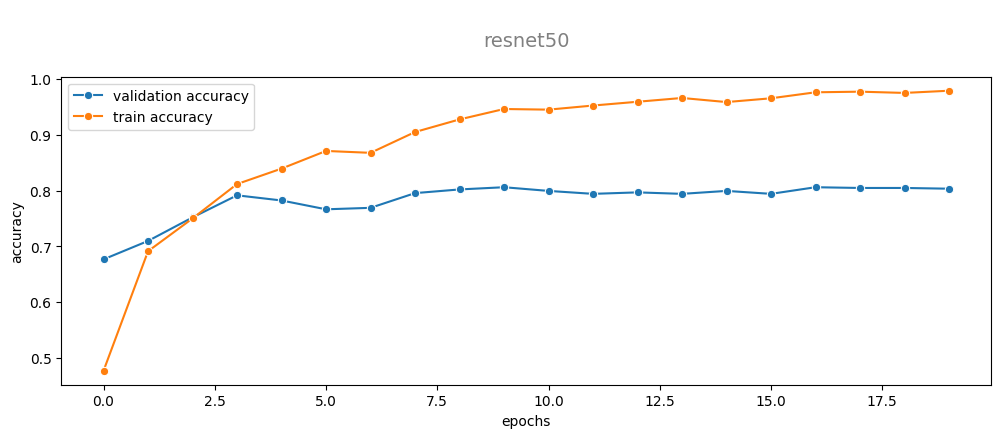

In [ ]:
## display train and validation accuracies and losses
resnet50_df = pd.read_csv(csv_files['resnet50'])
plot_val_train_accuracy(resnet50_df , 'resnet50')

### MobileNet pre_trained model

In [ ]:
# Step 1: Initialize ModelBuilder
model_builder_mobilenet = ModelBuilder(input_image_size, models_name[1], layers_name[1], fine_tune_at, learning_rate)

# Step 2: Build the model
model_mobilenet = model_builder_mobilenet.build_model()

# Step 3: Train the model
start_time = t.time()
history_mobilenet = model_mobilenet.fit(
    training_data,                     # Your training dataset
    validation_data=validation_data,       # Your validation dataset
    epochs=EPOCHS,                      # Define the number of epochs
    callbacks = [reduce_lr , CSVLogger(csv_files['mobilenet'])]
)
end_time = t.time()
runing_time_mobilenet = end_time - start_time

/opt/conda/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:449: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.2265 - loss: 6.4290 - val_accuracy: 0.5172 - val_loss: 1.2990 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.4860 - loss: 1.3491 - val_accuracy: 0.5607 - val_loss: 1.1338 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.5665 - loss: 1.1612 - val_accuracy: 0.6069 - val_loss: 1.0384 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.5999 - loss: 1.0666 - val_accuracy: 0.6478 - val_loss: 0.9368 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.6413 - loss: 0.9215 - val_accuracy: 0.7032 - val_loss: 0.8343 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.6797 - loss: 0.8214 - val_accuracy: 0.7005 - val_loss: 0.8009 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

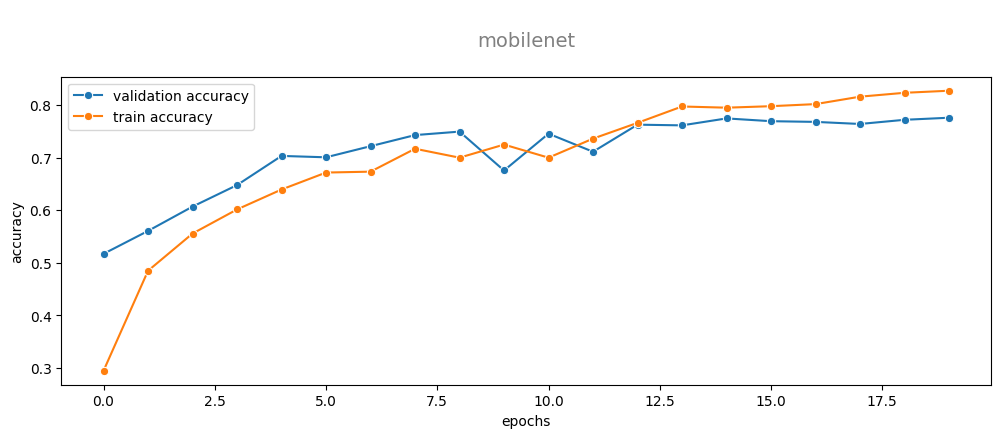

In [ ]:
## display train and validation accuracies and losses
mobilenet_df = pd.read_csv(csv_files['mobilenet'])
plot_val_train_accuracy(mobilenet_df , 'mobilenet')

### EfficientNet pre-trained model

In [ ]:
# Step 1: Initialize ModelBuilder
model_builder_efficientnet = ModelBuilder(input_image_size, models_name[2], layers_name[2], fine_tune_at, learning_rate)

# Step 2: Build the model
model_efficientnet = model_builder_efficientnet.build_model()

# Step 3: Train the model
start_time = t.time()
history_efficientnet = model_efficientnet.fit(
    training_data,                     # Your training dataset
    validation_data=validation_data,       # Your validation dataset
    epochs=EPOCHS,                      # Define the number of epochs
    callbacks = [reduce_lr , CSVLogger(csv_files['efficientnet'])]
)
end_time = t.time()
runing_time_efficient = end_time - start_time

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 709ms/step - accuracy: 0.3378 - loss: 27.5053 - val_accuracy: 0.6847 - val_loss: 1.8102 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 653ms/step - accuracy: 0.6096 - loss: 1.4288 - val_accuracy: 0.7612 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 649ms/step - accuracy: 0.7288 - loss: 0.8368 - val_accuracy: 0.7533 - val_loss: 0.7188 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 641ms/step - accuracy: 0.7275 - loss: 0.7905 - val_accuracy: 0.8338 - val_loss: 0.5575 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 642ms/step - accuracy: 0.8075 - loss: 0.5971 - val_accuracy: 0.8536 - val_loss: 0.5546 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 642ms/step - accuracy: 0.8281 - loss: 0.5117 - val_accuracy: 0.8021 - val_loss: 0.8582 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

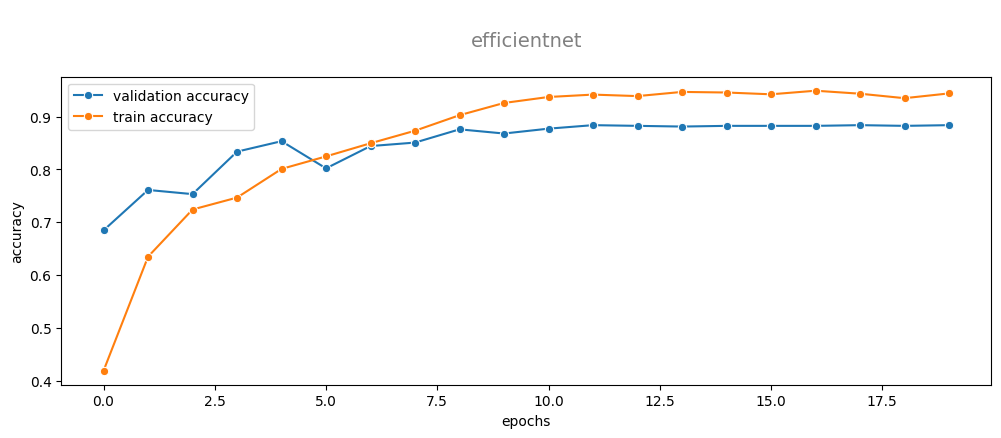

In [ ]:
efficientnet_df = pd.read_csv(csv_files['efficientnet'])
plot_val_train_accuracy(efficientnet_df , 'efficientnet')

## Time cost for each model

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


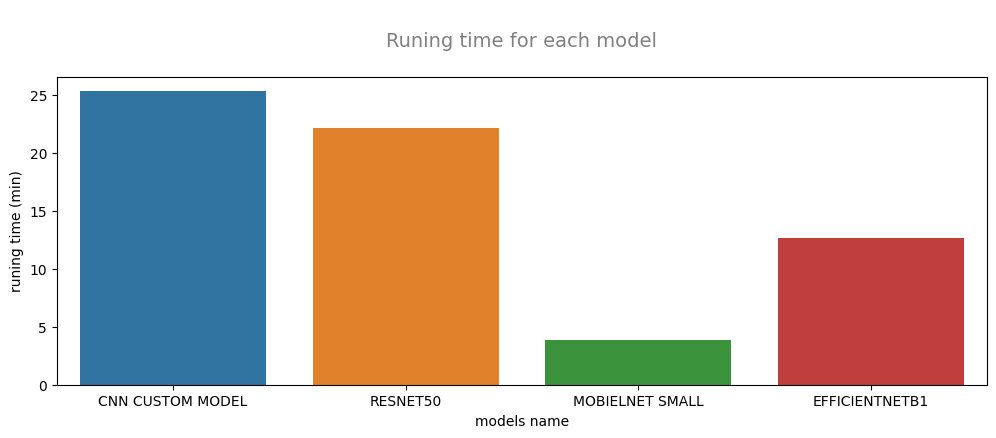

In [ ]:
time_cost = np.array([runing_time , runing_time_resnet , runing_time_mobilenet , runing_time_efficient])/60
models_name = ['CNN CUSTOM MODEL' , 'RESNET50', 'MOBIELNET SMALL', 'EFFICIENTNETB1']
plt.figure(figsize=(12,4) , dpi=100)
sns.barplot(x=models_name , y=time_cost )
plt.xlabel('models name')
plt.ylabel('runing time (min)')
plt.title('\nRuning time for each model\n',c='gray',fontsize=14);
#plt.xticks(rotation=90);